# City Power Load – Markov Chain V2  
## Solar Priority & Weather Uncertainty

---

### Scenario

This section **inherits the basic structure from the previous Markov Chain**:  
- The city’s electricity demand is categorized into **Peak**, **Mid**, and **Off-Peak** states.
- The system uses **time-dependent transition matrices** for **Daytime** and **Nighttime** to reflect changing usage patterns.

**This time, we add new elements**:
- During Daytime, **solar energy is prioritized** to offset consumption, so the grid supply only needs to cover any shortfall.
- However, **weather conditions** — such as **cloudiness**, **rain**, or even a **typhoon** — can reduce solar output unpredictably.
- When solar supply is insufficient due to sudden bad weather, the grid must **adjust proactively** to prevent under-supply.
- The model includes a **random “weather factor”** at each daytime step to simulate this uncertainty.  
  This can range from mild cloudiness to severe weather events that heavily reduce solar production.

---

### Goal

- Dynamically simulate how weather-dependent solar supply affects state transitions.
- Test how peak load can remain high if solar is unstable due to unexpected weather.
- Analyze how **preemptive grid adjustment** strategies help balance the load when solar supply drops sharply.

---

### Key Idea

A simple Markov Chain framework with **time-dependent transition matrices** can flexibly represent:
- **Local transition rules** that adapt to external weather conditions — cloudiness, rain, typhoon, and more.
- **Proactive policy shifts**, such as ramping up base grid generation when repeated severe weather is detected.
- The **global long-term behavior** that emerges from local uncertainty and dynamic adaptation.

This turns local, unpredictable conditions into a clear, testable picture of how a city’s energy system “breathes” and stabilizes over time.

---

### Next

In this notebook:
1. Define normal and weather-impacted Daytime matrices.
2. Simulate random weather impact at each step.
3. Optionally trigger a more aggressive grid matrix when prolonged bad weather is detected.
4. Visualize how the load distribution evolves under multiple weather scenarios.

---




In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
states = ['Peak', 'Mid', 'Off-Peak']

In [26]:
T_daytime_normal = np.array([
    [0.6, 0.3, 0.1],
    [0.3, 0.5, 0.2],
    [0.1, 0.4, 0.5]
])

T_daytime_cloudy = np.array([
    [0.75, 0.2, 0.05],
    [0.4, 0.5, 0.1],
    [0.2, 0.5, 0.3]
])

T_daytime_typhoon = np.array([
    [0.85, 0.1, 0.05],
    [0.5, 0.4, 0.1],
    [0.3, 0.4, 0.3]
])

T_nighttime_typhoon = np.array([
    [0.6, 0.3, 0.1],  # Peak Load sticks more
    [0.4, 0.4, 0.2],
    [0.2, 0.4, 0.4]
])

T_nighttime = np.array([
    [0.4, 0.4, 0.2],
    [0.3, 0.5, 0.2],
    [0.1, 0.4, 0.5]
])

In [27]:
prob_cloudy = 0.2 

In [28]:
P0 = np.array([1, 0, 0])
P_history = [P0]
weather_history = []

In [29]:
is_typhoon = False
typhoon_duration = 0

In [30]:
steps = 24

hour = i % 24

for i in range(steps):

    if 6 < i % 24 < 18:

        if is_typhoon:
            T = T_daytime_typhoon
            typhoon_duration -= 1
            if typhoon_duration <= 0:
                is_typhoon = False
            weather_history.append('Typhoon')

        else:
            r = np.random.rand()
            if r < prob_typhoon:
                is_typhoon = True
                typhoon_duration = 6  
                T = T_daytime_typhoon
                weather_history.append('Typhoon')

            elif r < prob_typhoon + prob_cloudy:
                T = T_daytime_cloudy
                weather_history.append('Cloudy')
            else:
                T = T_daytime_normal
                weather_history.append('Sunny')

    else:
        if is_typhoon:
            T = T_nighttime_typhoon   # <<< your new matrix
            typhoon_duration -= 1
            if typhoon_duration <= 0:
                is_typhoon = False
            weather_history.append('Typhoon-Night')
        else:
            T = T_nighttime
            weather_history.append('Night')

    P_next = P_history[-1] @ T
    P_history.append(P_next)

P_history = np.array(P_history)


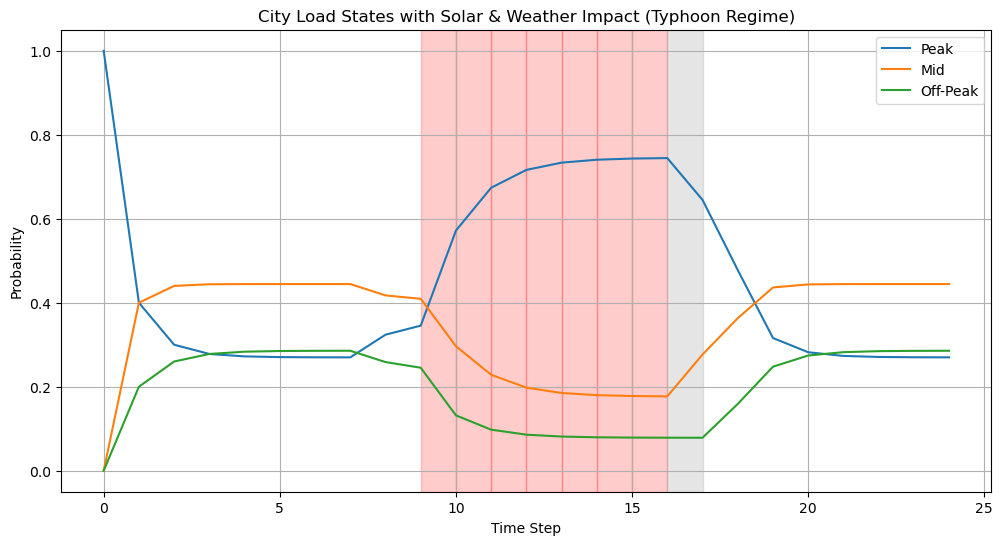

In [31]:
plt.figure(figsize=(12, 6))

for i, state in enumerate(states):
    plt.plot(range(steps+1), P_history[:, i], label=state)

for idx, condition in enumerate(weather_history):
    if condition == 'Typhoon':
        plt.axvspan(idx, idx+1, color='red', alpha=0.2)
    elif condition == 'Cloudy':
        plt.axvspan(idx, idx+1, color='gray', alpha=0.2)

plt.title('City Load States with Solar & Weather Impact (Typhoon Regime)')
plt.xlabel('Time Step')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

## Interpretation: Regime Switching Markov Chain

This simulation is not just about seeing random weather events;  
it demonstrates how a **Markov Chain integrates multiple local transition rules** into a single coherent global evolution.

---

### Key Mathematical Points

1️. **Local Matrix**
- Each transition matrix (e.g., Normal Daytime, Cloudy, Typhoon, Nighttime) defines a *local* state transition rule:
  $
  P_{t+1} = P_t T_i
  $
  where $T_i$ depends on external conditions (solar supply, weather, day vs. night).

2️. **Regime Switching**
- Real systems switch regimes: weather conditions, day-night cycles, or unexpected events like a typhoon.
- The Markov Chain framework captures this by dynamically selecting the appropriate local matrix at each time step.

3️. **Global Behavior**
- The long-term evolution is the result of multiplying many local matrices in sequence:
  $
  P_{t+1} = P_0 T_1 T_2 T_3 ... T_n
  $
- Even if each local matrix is simple, their combined effect shows how local uncertainty accumulates into a global load distribution.

4️. **Persistence**
- Sustained regimes (like a typhoon lasting multiple steps) illustrate how *local shocks* become *global shifts* in system behavior.
- This is the true power of the Markov Chain: turning local probabilistic rules into system-level insight.

---

### Final Takeaway

 **Key Insight:**  
> A Markov Chain with regime switching is a powerful tool for modeling any system where local conditions change over time.  
> It shows how local transition matrices interact and accumulate to shape the entire state distribution.

This makes the approach reusable for:
- Energy balancing with weather risk,
- Regime-dependent ODE/PDE models,
- Risk scenarios with multiple stochastic regimes.

